In [1]:
import numpy as np
import pandas as pd
import os
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import scipy
from statsmodels.stats.diagnostic import het_breuschpagan
import itertools

# 1. Read data

In [2]:
data = pd.read_csv('dataset.csv') 
data = data.drop(data.columns[0], axis=1)

In [3]:
data.head(3)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.166,1,-17.235,1,0.0763,0.9240,0.000006,0.101,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.359,0,-9.734,1,0.0557,0.2100,0.000000,0.117,0.120,76.332,4,acoustic


# 2. Cleaning - kpop

### Drop null
- Decided to drop nulls because there is only 1 record that accounts for all 3 nulls

In [4]:
data = data.dropna()

In [5]:
### Removing duplicate songs 
data = data.drop_duplicates(subset='track_id', keep='first', inplace=False)

In [6]:
### Calculating quantiles for song duration
quants = data.duration_ms.quantile([.0, 0.001, 0.01, 0.25, .5, 0.75, 0.99, 0.995, 0.999, 1])
quants

0.000       8586.000
0.001      35491.387
0.010      61871.850
0.250     173040.000
0.500     213295.500
0.750     264293.000
0.990     546010.980
0.995     634173.875
0.999    1088334.751
1.000    5237295.000
Name: duration_ms, dtype: float64

In [7]:
### Dropping 0.05% longest songs, over 10.5 min 
data2 = data[data['duration_ms'] < quants[0.995]]

In [8]:
data2.track_genre.unique()

array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'brazil',
       'breakbeat', 'british', 'cantopop', 'chicago-house', 'children',
       'chill', 'classical', 'club', 'comedy', 'country', 'dance',
       'dancehall', 'death-metal', 'deep-house', 'detroit-techno',
       'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm',
       'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk',
       'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove',
       'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'honky-tonk', 'house', 'idm', 'indian',
       'indie-pop', 'indie', 'industrial', 'iranian', 'j-dance', 'j-idol',
       'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino',
       'malay', 'mandopop', 'metal', 'metalcore', 'minimal-techno', 'mpb',
       'new-age', 'opera', 'pagode', 'party', 'piano', 'pop-film', 'pop',
       'pow

In [9]:
kpop_df = data2[data2['track_genre']=='k-pop']

In [10]:
kpop_df.head(2)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
65000,3hkC9EHFZNQPXrtl8WPHnX,Alka Yagnik;Arijit Singh,Tamasha,Agar Tum Saath Ho,73,341054,False,0.562,0.519,3,-8.744,1,0.0326,0.557,0.000268,0.172,0.415,122.925,4,k-pop
65001,45OX2jjEw1l7lOFJfDP9fv,LISA,LALISA,MONEY,78,168227,False,0.826,0.553,1,-10.121,0,0.2340,0.163,0.000041,0.135,0.400,140.037,4,k-pop


In [11]:
features = ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 
            'mode', 'speechiness', 'acousticness', 'instrumentalness', 
            'liveness', 'valence', 'tempo', 'time_signature']#'explicit'

(array([  5.,   1.,   2.,   4.,  33., 262., 150., 269., 163.,  22.]),
 array([ 0. ,  8.8, 17.6, 26.4, 35.2, 44. , 52.8, 61.6, 70.4, 79.2, 88. ]),
 <BarContainer object of 10 artists>)

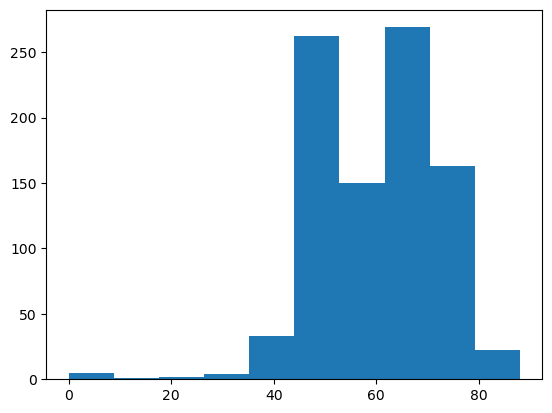

In [12]:
plt.hist(kpop_df.popularity)

<BarContainer object of 2 artists>

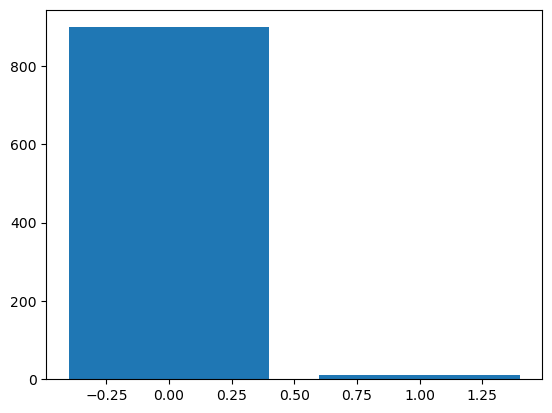

In [13]:
explicit_ct = kpop_df.explicit.value_counts()

plt.bar(explicit_ct.index, explicit_ct.values)

<BarContainer object of 12 artists>

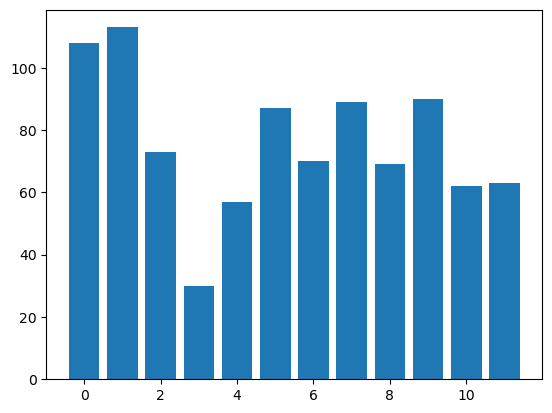

In [14]:
key_cts = kpop_df.key.value_counts()
plt.bar(key_cts.index, key_cts.values)

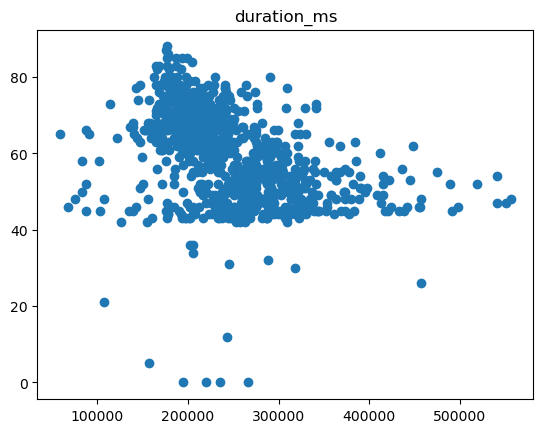

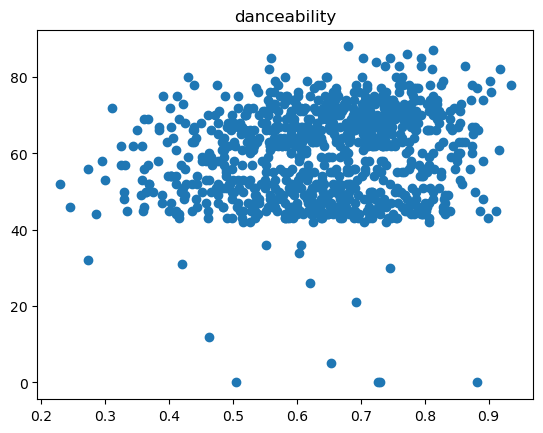

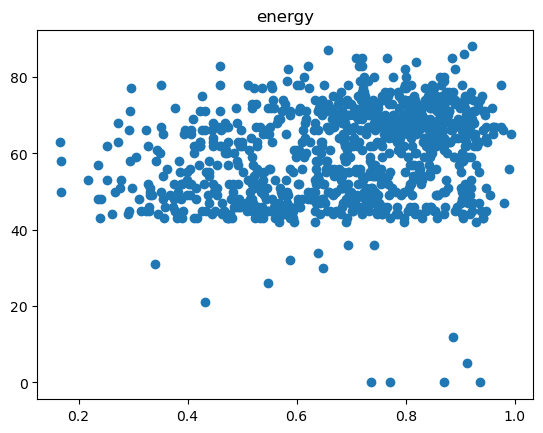

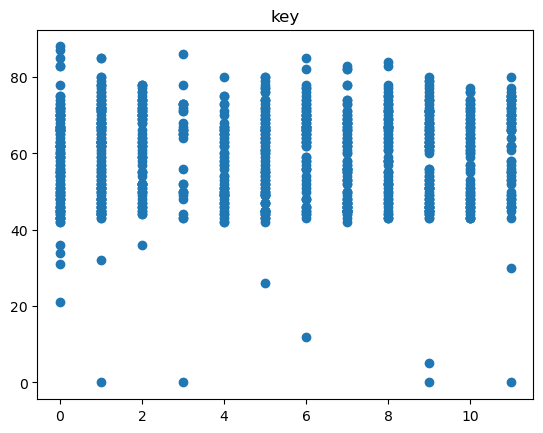

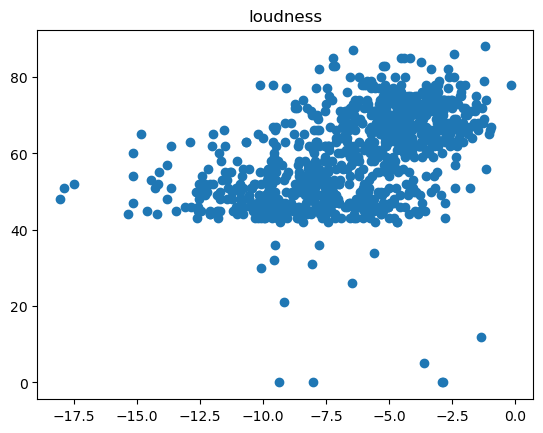

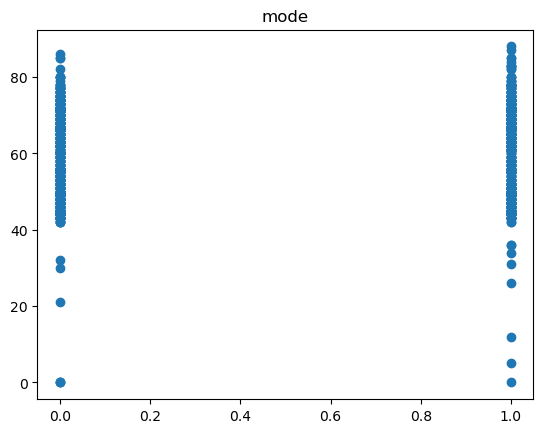

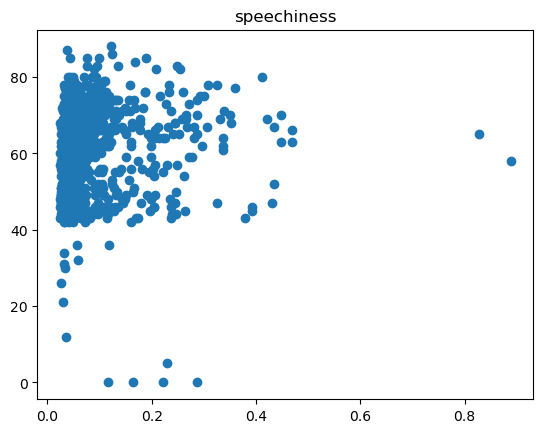

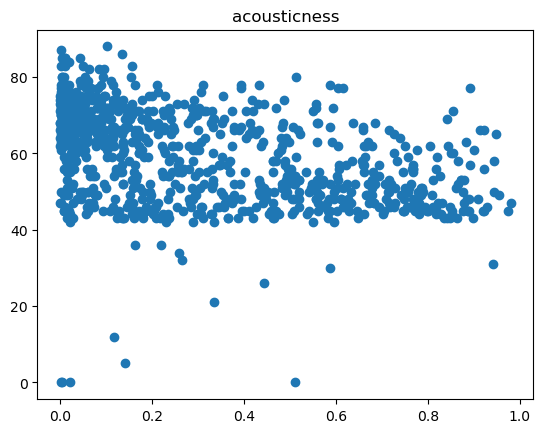

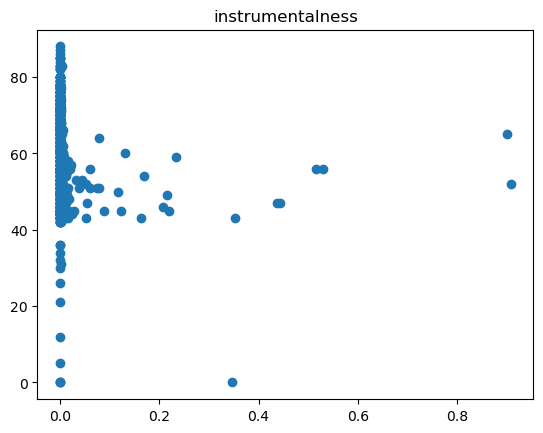

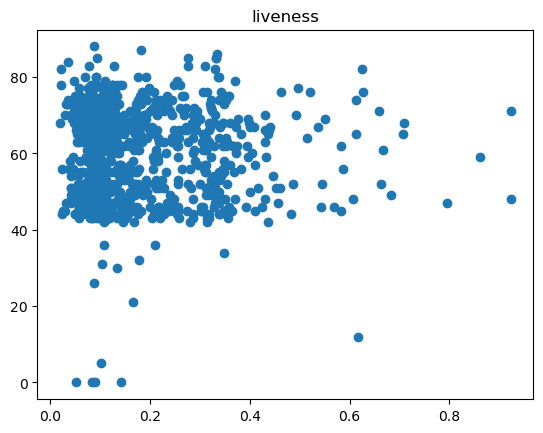

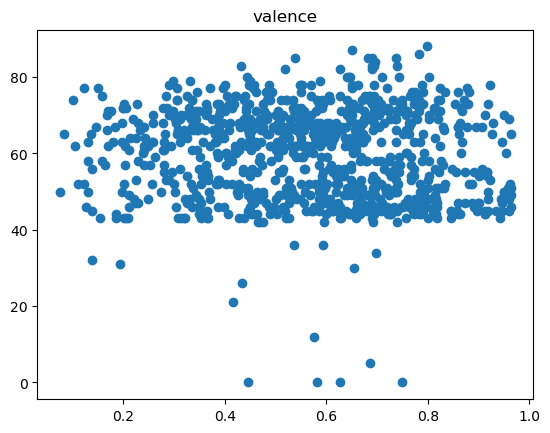

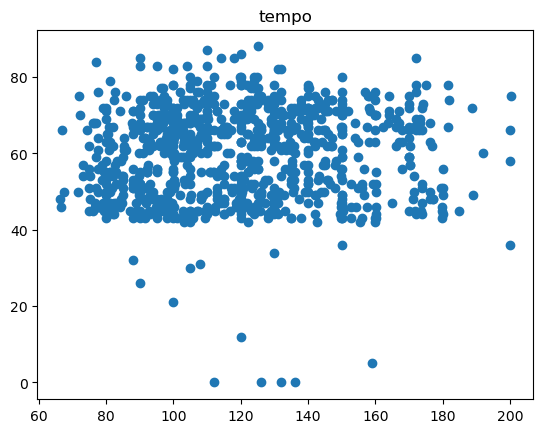

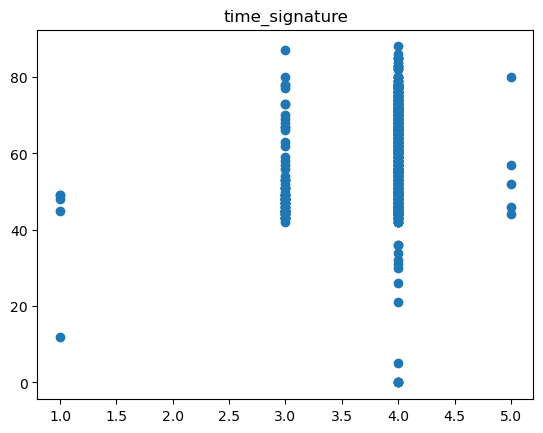

In [15]:
for i in features:
    plt.scatter(kpop_df[i], kpop_df.popularity)
    plt.title(i)
    plt.show()

# 3. Model Diagnostics - kpop

### VIF
- time_signature had high VIF, change to binary: 4/4 time or not

In [16]:
y, X = dmatrices('popularity ~ duration_ms + C(explicit) + danceability + energy + C(key) + loudness + C(mode) + speechiness + acousticness + instrumentalness + liveness + valence + tempo + C(time_signature)', data=kpop_df, return_type='dataframe')


In [17]:
vif = pd.DataFrame()
vif['VIF score'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns

In [18]:
vif[vif['VIF score']>10]

,VIF score,features
0,346.677068,Intercept
14,13.958272,C(time_signature)[T.3]
15,14.966907,C(time_signature)[T.4]


<BarContainer object of 4 artists>

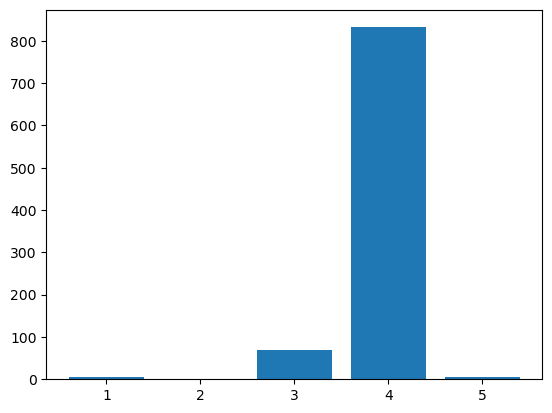

In [19]:
ts_cts = kpop_df.time_signature.value_counts()
plt.bar(ts_cts.index, ts_cts.values)

In [20]:
data3 = data2.copy()
data3['time_4'] = [i == 4 for i in data2['time_signature']]
kpop_df = data3[data3['track_genre'] =='k-pop']

In [21]:
kpop_df['time_4']

65000     True
65001     True
65002     True
65003     True
65004     True
         ...  
65995     True
65996     True
65997     True
65998     True
65999    False
Name: time_4, Length: 911, dtype: bool

In [22]:
y, X = dmatrices('popularity ~ duration_ms + C(explicit) + danceability + energy + C(key) + loudness + C(mode) + speechiness + acousticness + instrumentalness + liveness + valence + tempo + time_4', data=kpop_df, return_type='dataframe')


In [23]:
vif = pd.DataFrame()
vif['VIF score'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns

In [24]:
vif

,VIF score,features
0,171.254648,Intercept
1,1.041791,C(explicit)[T.True]
2,1.879892,C(key)[T.1]
3,1.596360,C(key)[T.2]
4,1.289546,C(key)[T.3]
5,1.471646,C(key)[T.4]
6,1.688756,C(key)[T.5]
7,1.557716,C(key)[T.6]
8,1.709932,C(key)[T.7]
9,1.568980,C(key)[T.8]


In [25]:
reg = smf.ols('popularity ~ duration_ms + C(explicit) + danceability + energy + C(key) + loudness + C(mode) + speechiness + acousticness + instrumentalness + liveness + valence + tempo + time_4', data=kpop_df).fit()

In [26]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     19.85
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           6.19e-67
Time:                        10:46:18   Log-Likelihood:                -3371.2
No. Observations:                 911   AIC:                             6792.
Df Residuals:                     886   BIC:                             6913.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              92.5761      4.305     21.503      0.000      84.127     101.026
C(explicit)[T.True]     6.6144      2.945      2.246      0.025       0.834      12.395
C(key)[T.1]             1.1857      1.368      0.866      0.386      -1.500       3.871
C(key)[T.2]             2.6886      1.531      1.756      0.079      -0.316       5.693
C(key)[T.3]             0.0056      2.093      0.003      0.998      -4.103       4.114
C(key)[T.4]             1.5427      1.648      0.936      0.349      -1.691       4.777
C(key)[T.5]             0.7477      1.455      0.514      0.607      -2.107       3.603
C(key)[T.6]             2.3586      1.542      1.530      0.126      -0.667       5.384
C(key)[T.7]             0.9424      1.449      0.650      0.516      -1.901       3.786
C(key)[T.8]             1.8697      1.557      1.200      0.230      -1.187       4.926
C(key)[T.9]             1.0839      1.444      0.751      0.453      -1.750       3.918
C(key)[T.10]            1.0068      1.609      0.626      0.532      -2.151       4.165
C(key)[T.11]            2.0818      1.615      1.289      0.198      -1.089       5.252
C(mode)[T.1]            1.3045      0.700      1.863      0.063      -0.070       2.679
time_4[T.True]          2.0570      1.270      1.619      0.106      -0.437       4.551
duration_ms         -2.743e-05   6.09e-06     -4.502      0.000   -3.94e-05   -1.55e-05
danceability           -5.3675      3.032     -1.770      0.077     -11.319       0.583
energy                -19.7445      3.465     -5.699      0.000     -26.544     -12.945
loudness                1.6875      0.190      8.874      0.000       1.314       2.061
speechiness             2.6918      4.316      0.624      0.533      -5.780      11.163
acousticness          -13.2508      1.746     -7.588      0.000     -16.678      -9.824
instrumentalness      -15.1205      5.725     -2.641      0.008     -26.356      -3.885
liveness                1.4595      2.596      0.562      0.574      -3.635       6.554
valence                 1.7431      2.034      0.857      0.392      -2.249       5.735
tempo                   0.0004      0.013      0.035      0.972      -0.024       0.025
==============================================================================
Omnibus:                      381.791   Durbin-Watson:                   1.537
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3483.077
Skew:                          -1.663   Prob(JB):                         0.00
Kurtosis:                      11.983   Cond. No.                     4.43e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.43e+06. 

### Influential Points
- Eliminated 23 points

In [27]:
infl = reg.get_influence()

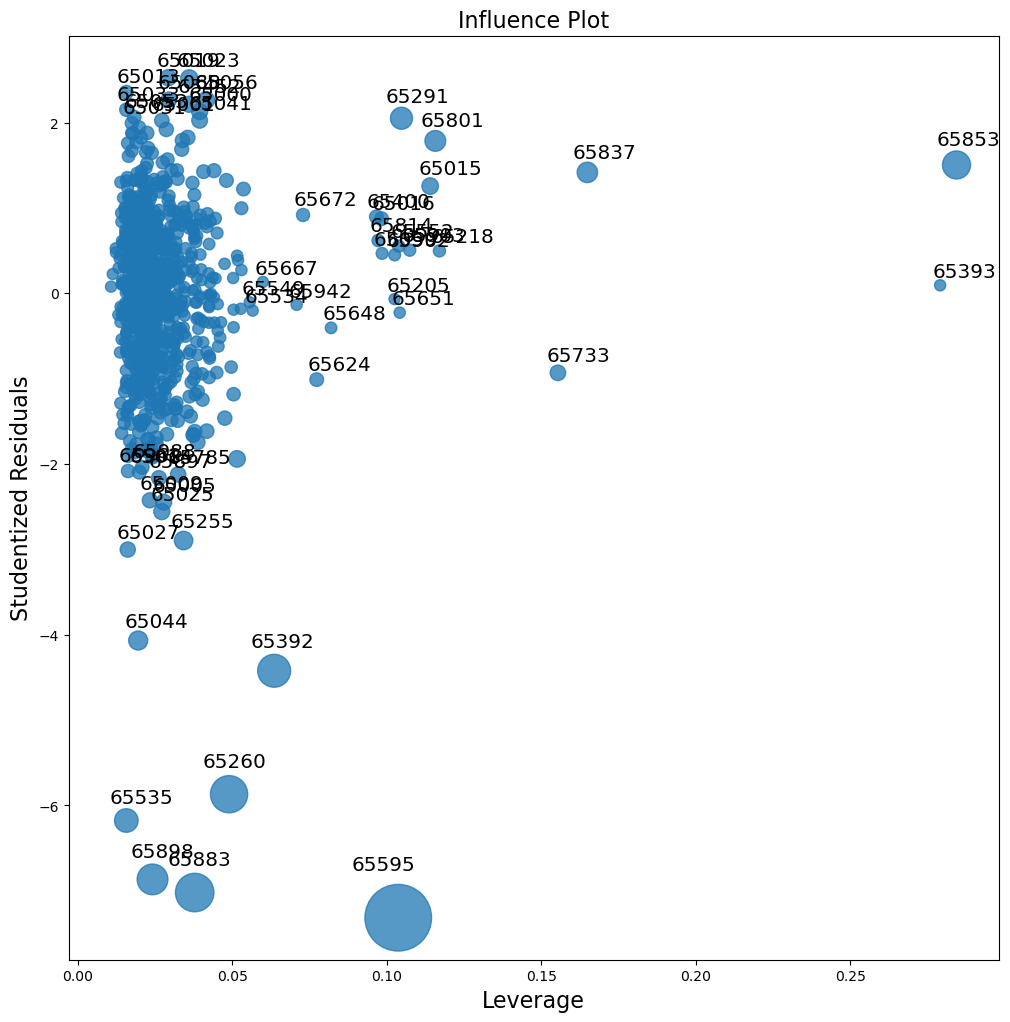

In [28]:
fig, ax = plt.subplots(figsize=(12,12))
fig=sm.graphics.influence_plot(reg,ax=ax, criterion="cooks") 

In [31]:
n = len(kpop_df)
p = 15
t_crit = scipy.stats.t.ppf(0.975, df=n-p-1)
cook_crit = 4/n

In [32]:
reg_studs = infl.resid_studentized_external

In [33]:
atyp_studs = np.abs(reg_studs) > t_crit
reg_studs[atyp_studs]

array([ 2.13115339,  2.02533176, -2.44632275, -2.42462096,  2.35610573,
       -2.09522948,  2.52659458,  2.51854341, -2.55746013, -3.00165757,
        1.99375436,  2.15145118,  2.0277026 , -4.0672885 ,  2.06546165,
        2.26400711,  2.27003944, -2.89562623, -5.86803864,  2.05172766,
       -4.42180165,  2.2158522 , -6.17602232, -7.31513123, -2.12138772,
       -7.020027  , -2.1621638 , -6.86592166, -2.08167381, -2.03861765])

In [34]:
inflsum = infl.summary_frame()
reg_cook = inflsum.cooks_d

In [38]:
kpop_df['ext_stud_resid'] = reg_studs
kpop_df['cooks_d'] = reg_cook

kpop_df.head()

/var/folders/jk/pgjk_zys001_s284g_c6wyww0000gn/T/ipykernel_38756/1485337512.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kpop_df['ext_stud_resid'] = reg_studs
/var/folders/jk/pgjk_zys001_s284g_c6wyww0000gn/T/ipykernel_38756/1485337512.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kpop_df['cooks_d'] = reg_cook


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,time_4,ext_stud_resid,cooks_d
65000,3hkC9EHFZNQPXrtl8WPHnX,Alka Yagnik;Arijit Singh,Tamasha,Agar Tum Saath Ho,73,341054,False,0.562,0.519,3,...,0.5570,0.000268,0.1720,0.415,122.925,4,k-pop,True,2.131153,0.007424
65001,45OX2jjEw1l7lOFJfDP9fv,LISA,LALISA,MONEY,78,168227,False,0.826,0.553,1,...,0.1630,0.000041,0.1350,0.400,140.037,4,k-pop,True,2.025332,0.004570
65002,5aucVLKiumD89mxVCB4zvS,Crush;j-hope,Rush Hour,Rush Hour (Feat. j-hope of BTS),83,177302,False,0.738,0.714,0,...,0.1570,0.000000,0.3100,0.740,95.035,4,k-pop,True,1.876682,0.002513
65003,1R0hxCA5R7z5TiaXBZR7Mf,JENNIE,SOLO,SOLO,73,169566,False,0.752,0.642,3,...,0.0861,0.000000,0.0953,0.388,95.043,4,k-pop,True,0.871833,0.001218
65004,4a9tbd947vo9K8Vti9JwcI,BTS;Halsey,MAP OF THE SOUL : PERSONA,Boy With Luv (feat. Halsey),80,229773,False,0.645,0.862,11,...,0.0933,0.000000,0.1930,0.803,119.947,4,k-pop,True,1.769023,0.002411


In [39]:
clean_kpop = kpop_df[(abs(kpop_df['ext_stud_resid'])<t_crit) & (abs(kpop_df['cooks_d'])<cook_crit)]
clean_kpop

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,time_4,ext_stud_resid,cooks_d
65002,5aucVLKiumD89mxVCB4zvS,Crush;j-hope,Rush Hour,Rush Hour (Feat. j-hope of BTS),83,177302,False,0.738,0.714,0,...,0.1570,0.000000,0.3100,0.740,95.035,4,k-pop,True,1.876682,0.002513
65003,1R0hxCA5R7z5TiaXBZR7Mf,JENNIE,SOLO,SOLO,73,169566,False,0.752,0.642,3,...,0.0861,0.000000,0.0953,0.388,95.043,4,k-pop,True,0.871833,0.001218
65004,4a9tbd947vo9K8Vti9JwcI,BTS;Halsey,MAP OF THE SOUL : PERSONA,Boy With Luv (feat. Halsey),80,229773,False,0.645,0.862,11,...,0.0933,0.000000,0.1930,0.803,119.947,4,k-pop,True,1.769023,0.002411
65006,2KZ3sNqPogEyMUUH6A5HFy,LISA,LALISA,LALISA,73,200689,False,0.804,0.652,8,...,0.0267,0.000782,0.1180,0.854,150.076,4,k-pop,True,0.701395,0.000479
65007,2kOH2QZB7F7I1iVXqwKuBF,Dhanush;Anirudh Ravichander,"Mayakkama Kalakkama (From ""Thiruchitrambalam"")","Mayakkama Kalakkama (From ""Thiruchitrambalam"")",77,142258,False,0.789,0.536,9,...,0.6040,0.000002,0.0880,0.877,124.029,4,k-pop,True,1.568005,0.002933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65994,422rzxQzO9Q3FaeMhvgVY4,Yuvan Shankar Raja;Sruthi S,Taramani (Original Motion Picture Soundtrack),Unnai Unnai Unnai,43,176999,False,0.585,0.381,1,...,0.6490,0.006340,0.1040,0.209,79.930,4,k-pop,True,-1.496737,0.001947
65995,6yN6AP2qkoGIjhF3VzUOkO,Alka Yagnik;Kumar Sanu,Kahin Pyaar Na Ho Jaaye (Original Motion Pictu...,Kahin Pyaar Na Ho Jaaye,44,318546,False,0.622,0.748,1,...,0.1610,0.000000,0.1000,0.725,128.844,4,k-pop,True,-1.286966,0.000930
65996,5kkgQsFJY5MVXChIfY0bl9,Yuvan Shankar Raja;KK;Sadhana Sargam,Dass,Sakka Podu,42,257743,False,0.806,0.633,0,...,0.2890,0.000000,0.1690,0.740,103.060,4,k-pop,True,-1.905075,0.002370
65997,4jUEHIrc443f743JbyLN0y,BLACKPINK,BLACKPINK IN YOUR AREA (Japanese Version),DDU-DU DDU-DU - Japanese Version,61,209493,False,0.703,0.845,11,...,0.0296,0.000000,0.2130,0.428,139.936,4,k-pop,True,-0.462835,0.000177


In [40]:
reg2 = smf.ols('popularity ~ duration_ms + C(explicit) + danceability + energy + C(key) + loudness + C(mode) + speechiness + acousticness + instrumentalness + liveness + valence + tempo + time_4', data=clean_kpop).fit()

In [41]:
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     36.24
Date:                Mon, 29 Jan 2024   Prob (F-statistic):          1.69e-112
Time:                        10:47:08   Log-Likelihood:                -2994.9
No. Observations:                 871   AIC:                             6040.
Df Residuals:                     846   BIC:                             6159.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              92.5573      3.409     27.151      0.000      85.866      99.248
C(explicit)[T.True]    10.4636      2.610      4.008      0.000       5.340      15.587
C(key)[T.1]             1.0967      1.092      1.005      0.315      -1.046       3.239
C(key)[T.2]             2.8534      1.213      2.353      0.019       0.473       5.234
C(key)[T.3]             0.2636      1.745      0.151      0.880      -3.162       3.689
C(key)[T.4]             0.6264      1.304      0.480      0.631      -1.933       3.186
C(key)[T.5]             0.1442      1.156      0.125      0.901      -2.125       2.414
C(key)[T.6]             2.7333      1.217      2.246      0.025       0.344       5.122
C(key)[T.7]             0.6512      1.148      0.567      0.571      -1.603       2.905
C(key)[T.8]             2.0442      1.238      1.651      0.099      -0.386       4.474
C(key)[T.9]             1.3407      1.150      1.166      0.244      -0.916       3.597
C(key)[T.10]            0.4939      1.260      0.392      0.695      -1.978       2.966
C(key)[T.11]            2.7043      1.289      2.098      0.036       0.174       5.234
C(mode)[T.1]            1.1137      0.552      2.019      0.044       0.031       2.197
time_4[T.True]          2.5549      1.015      2.517      0.012       0.562       4.547
duration_ms         -2.733e-05   4.91e-06     -5.562      0.000    -3.7e-05   -1.77e-05
danceability           -6.5737      2.396     -2.743      0.006     -11.277      -1.870
energy                -18.4670      2.758     -6.696      0.000     -23.880     -13.053
loudness                1.7510      0.153     11.454      0.000       1.451       2.051
speechiness             7.8835      3.912      2.015      0.044       0.206      15.561
acousticness          -13.3420      1.384     -9.643      0.000     -16.058     -10.626
instrumentalness      -17.0332      5.599     -3.042      0.002     -28.023      -6.043
liveness               -0.2645      2.070     -0.128      0.898      -4.327       3.798
valence                 1.4763      1.601      0.922      0.357      -1.667       4.619
tempo                   0.0037      0.010      0.372      0.710      -0.016       0.023
==============================================================================
Omnibus:                        9.392   Durbin-Watson:                   1.336
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                8.577
Skew:                          -0.192   Prob(JB):                       0.0137
Kurtosis:                       2.702   Cond. No.                     5.51e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.51e+06. 

### Heteroscedasticity
- Seems to be slightly irregular but passes breuschpagan test, so will not use robust standard errors

In [42]:
pred = reg2.fittedvalues
res = reg2.resid

Text(0.5, 1.0, 'Fitted Values vs. Residuals')

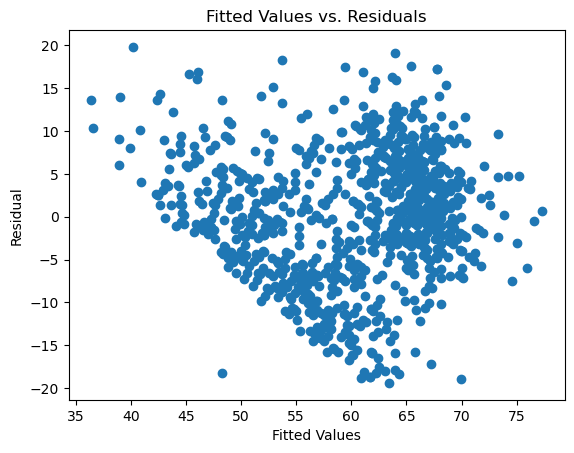

In [43]:
plt.scatter(pred, res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

In [44]:
bp_test = het_breuschpagan(res, reg2.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 30.25490586632765, 'LM-Test p-value': 0.1764463214919298}


### Normality

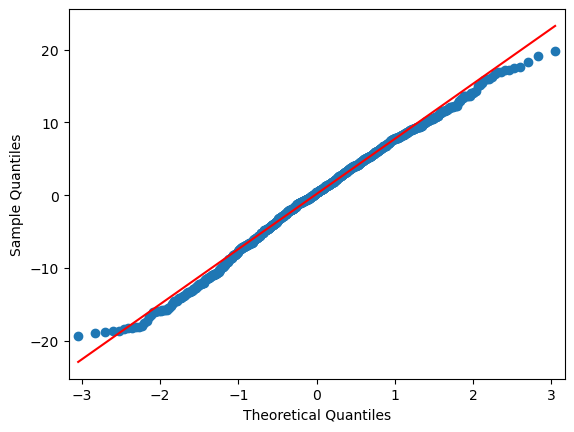

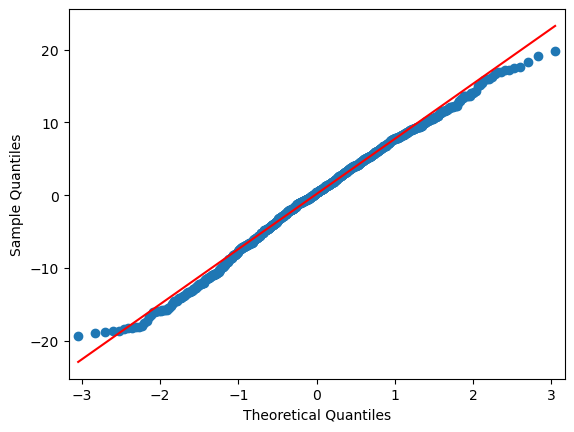

In [45]:
sm.qqplot(res, line='q')

(array([ 25.,  42.,  70., 126., 166., 178., 139.,  86.,  26.,  13.]),
 array([-19.41190216, -15.4873279 , -11.56275365,  -7.63817939,
         -3.71360514,   0.21096911,   4.13554337,   8.06011762,
         11.98469188,  15.90926613,  19.83384038]),
 <BarContainer object of 10 artists>)

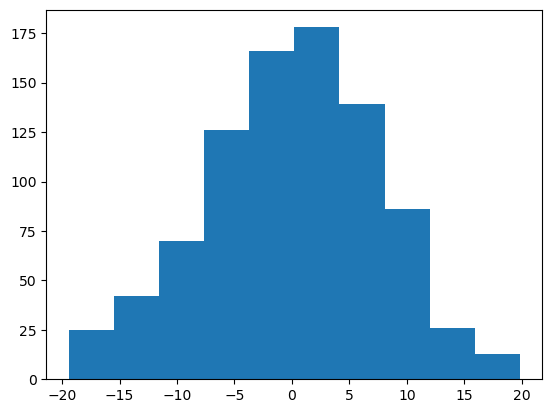

In [46]:
plt.hist(res)

In [47]:
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     36.24
Date:                Mon, 29 Jan 2024   Prob (F-statistic):          1.69e-112
Time:                        10:47:17   Log-Likelihood:                -2994.9
No. Observations:                 871   AIC:                             6040.
Df Residuals:                     846   BIC:                             6159.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              92.5573      3.409     27.151      0.000      85.866      99.248
C(explicit)[T.True]    10.4636      2.610      4.008      0.000       5.340      15.587
C(key)[T.1]             1.0967      1.092      1.005      0.315      -1.046       3.239
C(key)[T.2]             2.8534      1.213      2.353      0.019       0.473       5.234
C(key)[T.3]             0.2636      1.745      0.151      0.880      -3.162       3.689
C(key)[T.4]             0.6264      1.304      0.480      0.631      -1.933       3.186
C(key)[T.5]             0.1442      1.156      0.125      0.901      -2.125       2.414
C(key)[T.6]             2.7333      1.217      2.246      0.025       0.344       5.122
C(key)[T.7]             0.6512      1.148      0.567      0.571      -1.603       2.905
C(key)[T.8]             2.0442      1.238      1.651      0.099      -0.386       4.474
C(key)[T.9]             1.3407      1.150      1.166      0.244      -0.916       3.597
C(key)[T.10]            0.4939      1.260      0.392      0.695      -1.978       2.966
C(key)[T.11]            2.7043      1.289      2.098      0.036       0.174       5.234
C(mode)[T.1]            1.1137      0.552      2.019      0.044       0.031       2.197
time_4[T.True]          2.5549      1.015      2.517      0.012       0.562       4.547
duration_ms         -2.733e-05   4.91e-06     -5.562      0.000    -3.7e-05   -1.77e-05
danceability           -6.5737      2.396     -2.743      0.006     -11.277      -1.870
energy                -18.4670      2.758     -6.696      0.000     -23.880     -13.053
loudness                1.7510      0.153     11.454      0.000       1.451       2.051
speechiness             7.8835      3.912      2.015      0.044       0.206      15.561
acousticness          -13.3420      1.384     -9.643      0.000     -16.058     -10.626
instrumentalness      -17.0332      5.599     -3.042      0.002     -28.023      -6.043
liveness               -0.2645      2.070     -0.128      0.898      -4.327       3.798
valence                 1.4763      1.601      0.922      0.357      -1.667       4.619
tempo                   0.0037      0.010      0.372      0.710      -0.016       0.023
==============================================================================
Omnibus:                        9.392   Durbin-Watson:                   1.336
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                8.577
Skew:                          -0.192   Prob(JB):                       0.0137
Kurtosis:                       2.702   Cond. No.                     5.51e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.51e+06. 

# 4. Feature selection - kpop

In [161]:
reg2.summary()
print(np.round(reg2.get_robustcov_results(cov_type = "HC0").summary2().tables[1], 5))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     36.24
Date:                Sun, 08 Oct 2023   Prob (F-statistic):          1.69e-112
Time:                        14:43:42   Log-Likelihood:                -2994.9
No. Observations:                 871   AIC:                             6040.
Df Residuals:                     846   BIC:                             6159.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              92.5573      3.409     27.151      0.000      85.866      99.248
C(explicit)[T.True]    10.4636      2.610      4.008      0.000       5.340      15.587
C(key)[T.1]             1.0967      1.092      1.005      0.315      -1.046       3.239
C(key)[T.2]             2.8534      1.213      2.353      0.019       0.473       5.234
C(key)[T.3]             0.2636      1.745      0.151      0.880      -3.162       3.689
C(key)[T.4]             0.6264      1.304      0.480      0.631      -1.933       3.186
C(key)[T.5]             0.1442      1.156      0.125      0.901      -2.125       2.414
C(key)[T.6]             2.7333      1.217      2.246      0.025       0.344       5.122
C(key)[T.7]             0.6512      1.148      0.567      0.571      -1.603       2.905
C(key)[T.8]             2.0442      1.238      1.651      0.099      -0.386       4.474
C(key)[T.9]             1.3407      1.150      1.166      0.244      -0.916       3.597
C(key)[T.10]            0.4939      1.260      0.392      0.695      -1.978       2.966
C(key)[T.11]            2.7043      1.289      2.098      0.036       0.174       5.234
C(mode)[T.1]            1.1137      0.552      2.019      0.044       0.031       2.197
time_4[T.True]          2.5549      1.015      2.517      0.012       0.562       4.547
duration_ms         -2.733e-05   4.91e-06     -5.562      0.000    -3.7e-05   -1.77e-05
danceability           -6.5737      2.396     -2.743      0.006     -11.277      -1.870
energy                -18.4670      2.758     -6.696      0.000     -23.880     -13.053
loudness                1.7510      0.153     11.454      0.000       1.451       2.051
speechiness             7.8835      3.912      2.015      0.044       0.206      15.561
acousticness          -13.3420      1.384     -9.643      0.000     -16.058     -10.626
instrumentalness      -17.0332      5.599     -3.042      0.002     -28.023      -6.043
liveness               -0.2645      2.070     -0.128      0.898      -4.327       3.798
valence                 1.4763      1.601      0.922      0.357      -1.667       4.619
tempo                   0.0037      0.010      0.372      0.710      -0.016       0.023
==============================================================================
Omnibus:                        9.392   Durbin-Watson:                   1.336
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                8.577
Skew:                          -0.192   Prob(JB):                       0.0137
Kurtosis:                       2.702   Cond. No.                     5.51e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.51e+06. 

In [167]:
clean_kpop.columns

Index(['track_id', 'artists', 'album_name', 'track_name', 'popularity',
       'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'track_genre', 'time_4',
       'ext_stud_resid', 'cooks_d'],
      dtype='object')

In [172]:
def fit_lr(X, y):
    X = sm.add_constant(X) 
    reg = sm.OLS(y, X).fit()
    
    return reg

In [196]:
X.key

65002     0
65003     3
65004    11
65006     8
65007     9
         ..
65994     1
65995     1
65996     0
65997    11
65999     0
Name: key, Length: 871, dtype: int64

In [207]:
X = clean_kpop[['duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
                'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                'valence', 'tempo', 'time_4']]
X_cut = X.drop(['key'], axis=1)
y = clean_kpop.popularity

In [221]:
X_dummies = pd.get_dummies(X, columns=['explicit', 'key', 'mode', 'time_4'])
X_dummies_cut = pd.get_dummies(X_cut, columns=['explicit', 'mode', 'time_4'], drop_first=True)

In [283]:
predictors = list(X_dummies_cut.columns)
metrics = list()
for k in range(0, len(predictors)+1):
    subsets = list(itertools.combinations(predictors, k))
    
    for subset in subsets:
        subset_X = X_dummies_cut[list(subset)]
        reg = fit_lr(subset_X, y)
        adj_r2 = reg.rsquared_adj 
        aic = reg.aic
        bic = reg.bic
        sse = sum(reg.resid**2)
        metrics.append((subset, adj_r2, aic, bic, sse))
    print(k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [285]:
metrics_df = pd.DataFrame(metrics) 
metrics_df.columns = ['subset', 'adj_r2', 'aic', 'bic', 'sse']

In [239]:
reg_full = sm.OLS(y, X_dummies_cut).fit()
sse_full = reg_full.ssr
sse_full

95820.28462641432

In [301]:
len(np.array(metrics_df.sse)/den)

8192

In [307]:
n = len(X_dummies_cut)
p = len(X_dummies_cut.columns)+1
k = [len(i) for i in metrics_df.subset]
den = sse_full/(n-p)
cp = np.array(metrics_df.sse)/den + 2*np.array(k) - n

metrics_df['mallows_cp'] = cp

In [312]:
metrics_df[metrics_df['mallows_cp']>0].sort_values('mallows_cp')[:5]

,subset,adj_r2,aic,bic,sse,mallows_cp
83,"(valence, explicit_True)",0.030946,6582.223190,6596.532116,96951.269076,0.115329
1063,"(instrumentalness, liveness, tempo, mode_1)",0.032352,6582.948862,6606.797072,96587.486923,0.861724
1079,"(liveness, valence, tempo, mode_1)",0.032050,6583.221073,6607.069283,96617.677793,1.131746
345,"(instrumentalness, liveness, explicit_True)",0.030353,6583.752178,6602.830746,96898.854810,1.646545
348,"(instrumentalness, valence, tempo)",0.030327,6583.775233,6602.853801,96901.419716,1.669485


In [315]:
metrics_df.sort_values('adj_r2', ascending=False)[:5]

,subset,adj_r2,aic,bic,sse,mallows_cp
7833,"(duration_ms, danceability, energy, loudness, ...",0.492075,6027.503248,6079.969310,50348.140936,-400.694963
8113,"(duration_ms, danceability, energy, loudness, ...",0.491988,6028.640106,6085.875809,50298.271726,-399.140985
8114,"(duration_ms, danceability, energy, loudness, ...",0.491586,6029.327948,6086.563652,50338.008736,-398.785584
8109,"(duration_ms, danceability, energy, loudness, ...",0.491535,6029.415495,6086.651198,50343.068615,-398.740329
8183,"(duration_ms, danceability, energy, loudness, ...",0.491492,6030.475586,6092.480932,50288.771999,-397.225949


In [264]:
metrics_df.sort_values(['aic'])[:5]

,subset,adj_r2,aic,bic
7833,"(duration_ms, danceability, energy, loudness, ...",0.492075,6027.503248,6079.969310
8113,"(duration_ms, danceability, energy, loudness, ...",0.491988,6028.640106,6085.875809
8114,"(duration_ms, danceability, energy, loudness, ...",0.491586,6029.327948,6086.563652
8109,"(duration_ms, danceability, energy, loudness, ...",0.491535,6029.415495,6086.651198
7188,"(duration_ms, danceability, energy, loudness, ...",0.490379,6029.419784,6077.116203


In [316]:
sel_sub = list(metrics_df.sort_values(['aic'])[:5].iloc[0].subset)
sel_sub

['duration_ms',
 'danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'explicit_True',
 'mode_1',
 'time_4_True']

In [317]:
X_select = X_dummies_cut[sel_sub]

In [318]:
X_select

,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,explicit_True,mode_1,time_4_True
65002,177302,0.738,0.714,-5.235,0.2490,0.1570,0.000000,0,1,1
65003,169566,0.752,0.642,-5.165,0.0869,0.0861,0.000000,0,0,1
65004,229773,0.645,0.862,-4.761,0.0845,0.0933,0.000000,0,0,1
65006,200689,0.804,0.652,-6.282,0.0898,0.0267,0.000782,0,1,1
65007,142258,0.789,0.536,-5.422,0.0424,0.6040,0.000002,0,0,1
...,...,...,...,...,...,...,...,...,...,...
65994,176999,0.585,0.381,-9.393,0.0302,0.6490,0.006340,0,1,1
65995,318546,0.622,0.748,-7.730,0.0437,0.1610,0.000000,0,1,1
65996,257743,0.806,0.633,-4.674,0.0487,0.2890,0.000000,0,0,1
65997,209493,0.703,0.845,-3.479,0.0682,0.0296,0.000000,0,0,1


In [319]:
sel_reg = fit_lr(X_select, y)

In [320]:
sel_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     85.29
Date:                Sun, 08 Oct 2023   Prob (F-statistic):          1.96e-121
Time:                        15:36:23   Log-Likelihood:                -3002.8
No. Observations:                 871   AIC:                             6028.
Df Residuals:                     860   BIC:                             6080.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               93.3194      2.845     32.798      0.000      87.735      98.904
duration_ms      -2.704e-05   4.85e-06     -5.575      0.000   -3.66e-05   -1.75e-05
danceability        -6.4069      2.200     -2.913      0.004     -10.724      -2.090
energy             -16.5452      2.407     -6.873      0.000     -21.270     -11.821
loudness             1.7212      0.146     11.795      0.000       1.435       2.008
speechiness          7.5859      3.853      1.969      0.049       0.023      15.149
acousticness       -13.1621      1.330     -9.893      0.000     -15.773     -10.551
instrumentalness   -17.7288      5.581     -3.176      0.002     -28.683      -6.774
explicit_True       10.1450      2.597      3.907      0.000       5.049      15.242
mode_1               1.2999      0.527      2.468      0.014       0.266       2.333
time_4_True          2.4438      0.989      2.471      0.014       0.503       4.385
==============================================================================
Omnibus:                        9.322   Durbin-Watson:                   1.342
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                8.715
Skew:                          -0.201   Prob(JB):                       0.0128
Kurtosis:                       2.720   Cond. No.                     5.49e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.49e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Metal Genre - cleaning (not used in write up)

In [371]:
data3.track_genre.unique()

array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'brazil',
       'breakbeat', 'british', 'cantopop', 'chicago-house', 'children',
       'chill', 'classical', 'club', 'comedy', 'country', 'dance',
       'dancehall', 'death-metal', 'deep-house', 'detroit-techno',
       'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm',
       'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk',
       'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove',
       'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'honky-tonk', 'house', 'idm', 'indian',
       'indie-pop', 'indie', 'industrial', 'iranian', 'j-dance', 'j-idol',
       'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino',
       'malay', 'mandopop', 'metal', 'metalcore', 'minimal-techno', 'mpb',
       'new-age', 'opera', 'pagode', 'party', 'piano', 'pop-film', 'pop',
       'pow

In [458]:
data3.groupby('track_genre').mean().popularity.sort_values(ascending=False)[:20]

/var/folders/jk/pgjk_zys001_s284g_c6wyww0000gn/T/ipykernel_15562/4140848484.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data3.groupby('track_genre').mean().popularity.sort_values(ascending=False)[:20]


track_genre
k-pop                59.522503
pop-film             59.096933
metal                56.513043
chill                53.738683
latino               51.788945
sad                  51.109929
grunge               50.587007
indian               49.765348
anime                48.776884
emo                  48.516649
reggaeton            48.383562
sertanejo            47.860775
piano                46.608312
progressive-house    46.537748
hard-rock            45.744711
pagode               45.583829
deep-house           45.573045
british              45.085106
mandopop             45.071019
metalcore            44.709902
Name: popularity, dtype: float64

In [474]:
metal_df = data3[data3['track_genre'] == 'metal']
len(metal_df)

230

<BarContainer object of 12 artists>

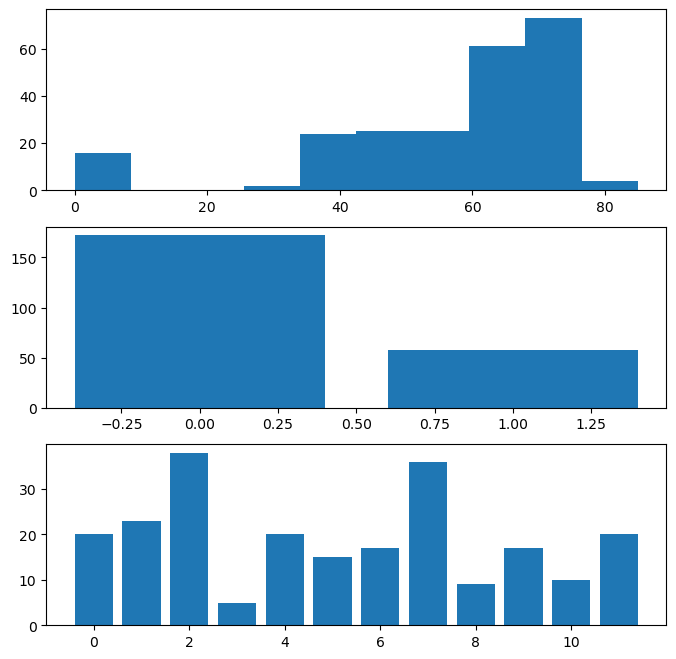

In [460]:
metal_ex = metal_df.explicit.value_counts()
metal_key = metal_df.key.value_counts()

fig, axs = plt.subplots(3, 1, figsize=(8,8))

axs[0].hist(metal_df.popularity)
axs[1].bar(metal_ex.index, metal_ex.values)
axs[2].bar(metal_key.index, metal_key.values)

In [412]:
features = ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 
            'mode', 'speechiness', 'acousticness', 'instrumentalness', 
            'liveness', 'valence', 'tempo', 'time_signature']#'explicit'

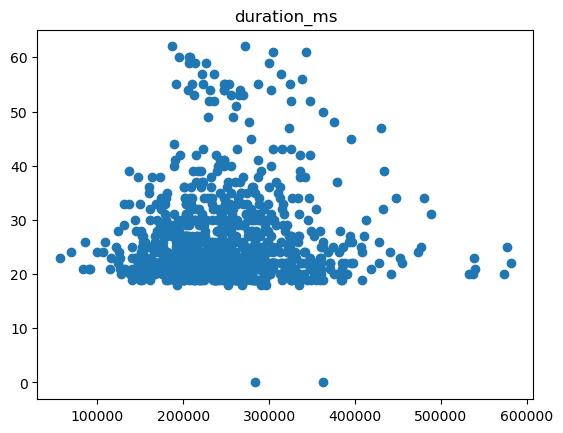

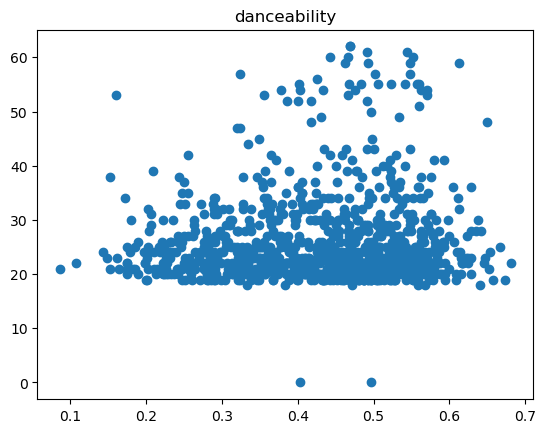

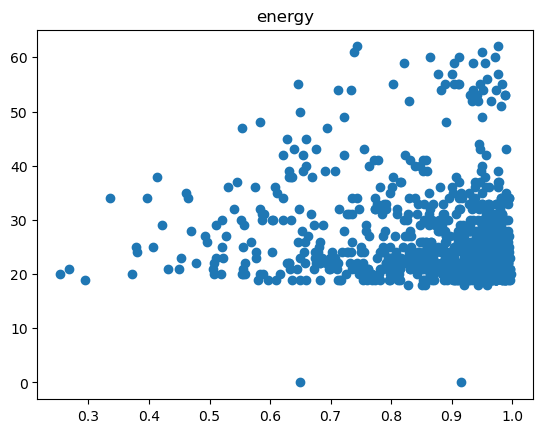

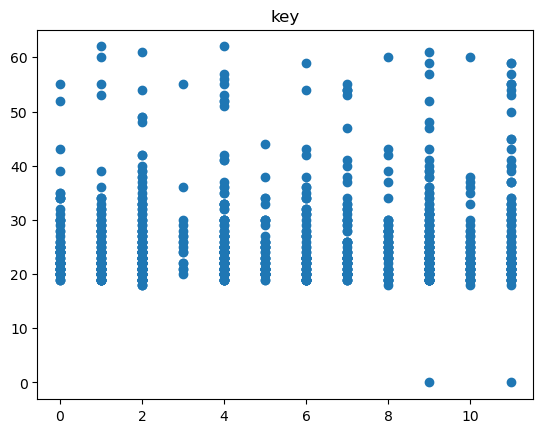

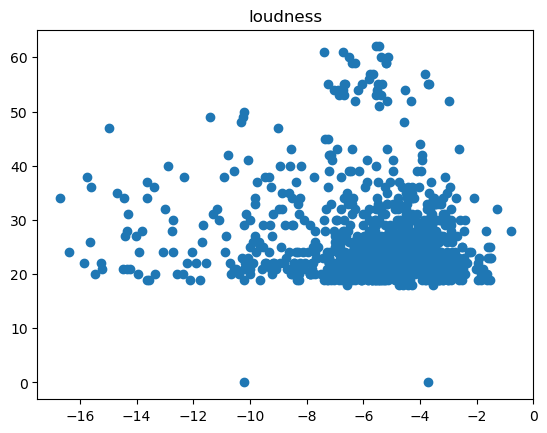

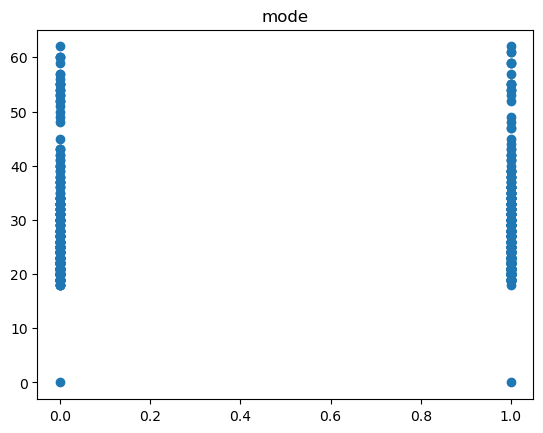

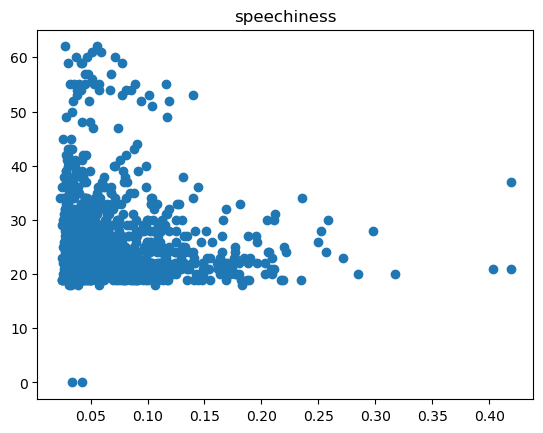

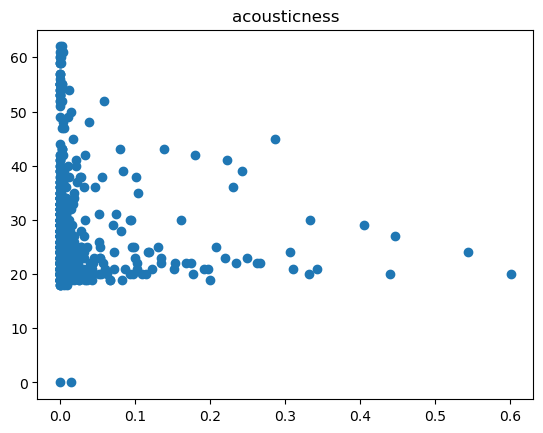

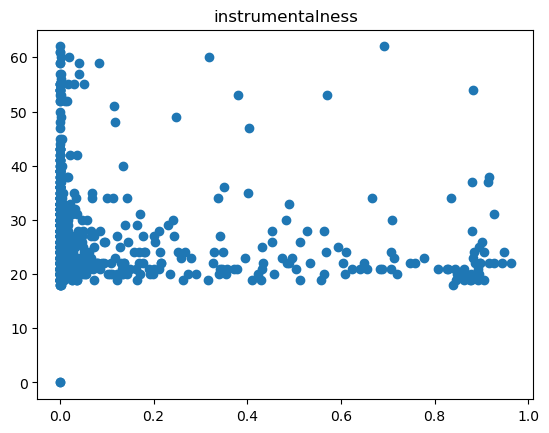

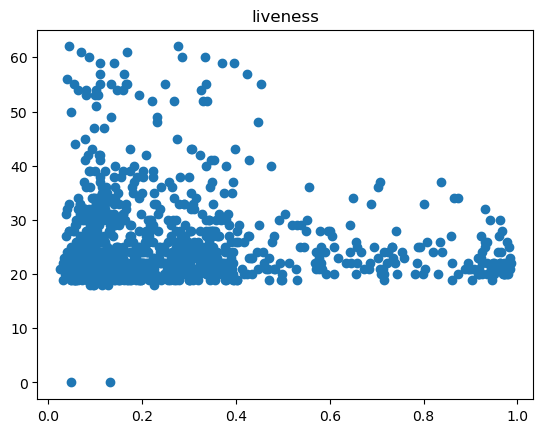

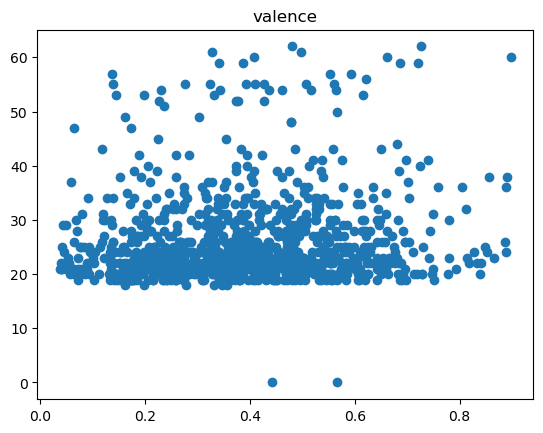

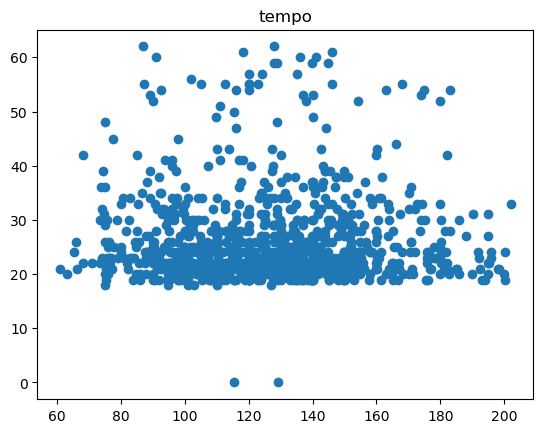

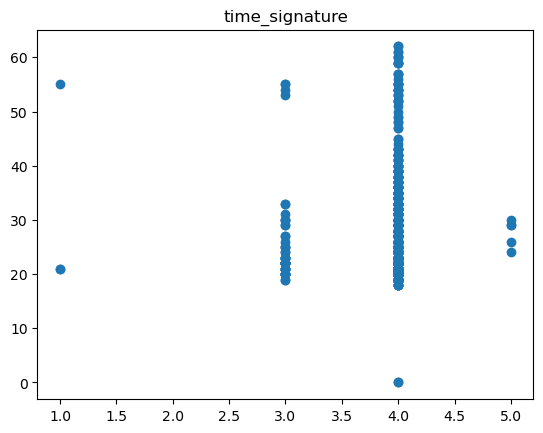

In [413]:
for i in features:
    plt.scatter(metal_df[i], metal_df.popularity)
    plt.title(i)
    plt.show()

# 3. Model Diagnostics Metal (not used)

### VIF

In [461]:
y, X = dmatrices('popularity ~ duration_ms + C(explicit) + danceability + energy + C(key) + loudness + C(mode) + speechiness + acousticness + instrumentalness + liveness + valence + tempo + C(time_4)', data=metal_df, return_type='dataframe')

In [462]:
vif_metal = pd.DataFrame()
vif_metal['VIF score'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_metal['features'] = X.columns

In [463]:
vif_metal[vif_metal['VIF score']>10]

,VIF score,features
0,260.60001,Intercept


In [421]:
vif_metal

,VIF score,features
0,224.511489,Intercept
1,1.105412,C(explicit)[T.True]
2,2.305883,C(key)[T.1]
3,2.535713,C(key)[T.2]
4,1.241098,C(key)[T.3]
5,2.539115,C(key)[T.4]
6,1.679852,C(key)[T.5]
7,1.865233,C(key)[T.6]
8,1.886816,C(key)[T.7]
9,1.711987,C(key)[T.8]


In [464]:
reg_metal = smf.ols('popularity ~ duration_ms + C(explicit) + danceability + energy + C(key) + loudness + C(mode) + speechiness + acousticness + instrumentalness + liveness + valence + tempo + time_4', data=metal_df).fit()

In [466]:
reg_metal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.122
Date:                Sun, 08 Oct 2023   Prob (F-statistic):              0.322
Time:                        16:23:26   Log-Likelihood:                -988.84
No. Observations:                 230   AIC:                             2028.
Df Residuals:                     205   BIC:                             2114.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              77.9165     20.092      3.878      0.000      38.302     117.531
C(explicit)[T.True]     7.1516      3.499      2.044      0.042       0.254      14.050
C(key)[T.1]             1.9296      6.143      0.314      0.754     -10.183      14.042
C(key)[T.2]             4.6979      5.511      0.852      0.395      -6.169      15.564
C(key)[T.3]            12.7843     10.277      1.244      0.215      -7.478      33.046
C(key)[T.4]            10.5725      6.489      1.629      0.105      -2.220      23.365
C(key)[T.5]             7.7467      6.844      1.132      0.259      -5.747      21.240
C(key)[T.6]            11.7067      6.650      1.760      0.080      -1.405      24.819
C(key)[T.7]             6.0558      5.541      1.093      0.276      -4.868      16.980
C(key)[T.8]            12.7014      7.952      1.597      0.112      -2.977      28.379
C(key)[T.9]             2.0010      6.496      0.308      0.758     -10.807      14.809
C(key)[T.10]            3.5846      7.718      0.464      0.643     -11.632      18.802
C(key)[T.11]           11.0033      6.197      1.776      0.077      -1.214      23.221
C(mode)[T.1]           -0.8001      2.816     -0.284      0.777      -6.352       4.752
time_4[T.True]          0.1181      5.054      0.023      0.981      -9.847      10.083
duration_ms          8.916e-06   2.14e-05      0.417      0.677   -3.32e-05     5.1e-05
danceability           -8.4025     14.471     -0.581      0.562     -36.934      20.128
energy                -16.6483     15.940     -1.044      0.298     -48.075      14.778
loudness                0.7484      0.979      0.764      0.446      -1.182       2.679
speechiness             2.8171     29.161      0.097      0.923     -54.678      60.312
acousticness          -20.6417     17.454     -1.183      0.238     -55.055      13.771
instrumentalness        4.8358     10.813      0.447      0.655     -16.482      26.154
liveness                1.5847      8.276      0.191      0.848     -14.732      17.902
valence                -7.0009      7.502     -0.933      0.352     -21.792       7.790
tempo                  -0.0511      0.048     -1.059      0.291      -0.146       0.044
==============================================================================
Omnibus:                       59.447   Durbin-Watson:                   1.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.384
Skew:                          -1.323   Prob(JB):                     1.07e-24
Kurtosis:                       5.125   Cond. No.                     6.55e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.55e+06. 

### Influential Points

In [467]:
infl = reg_metal.get_influence()

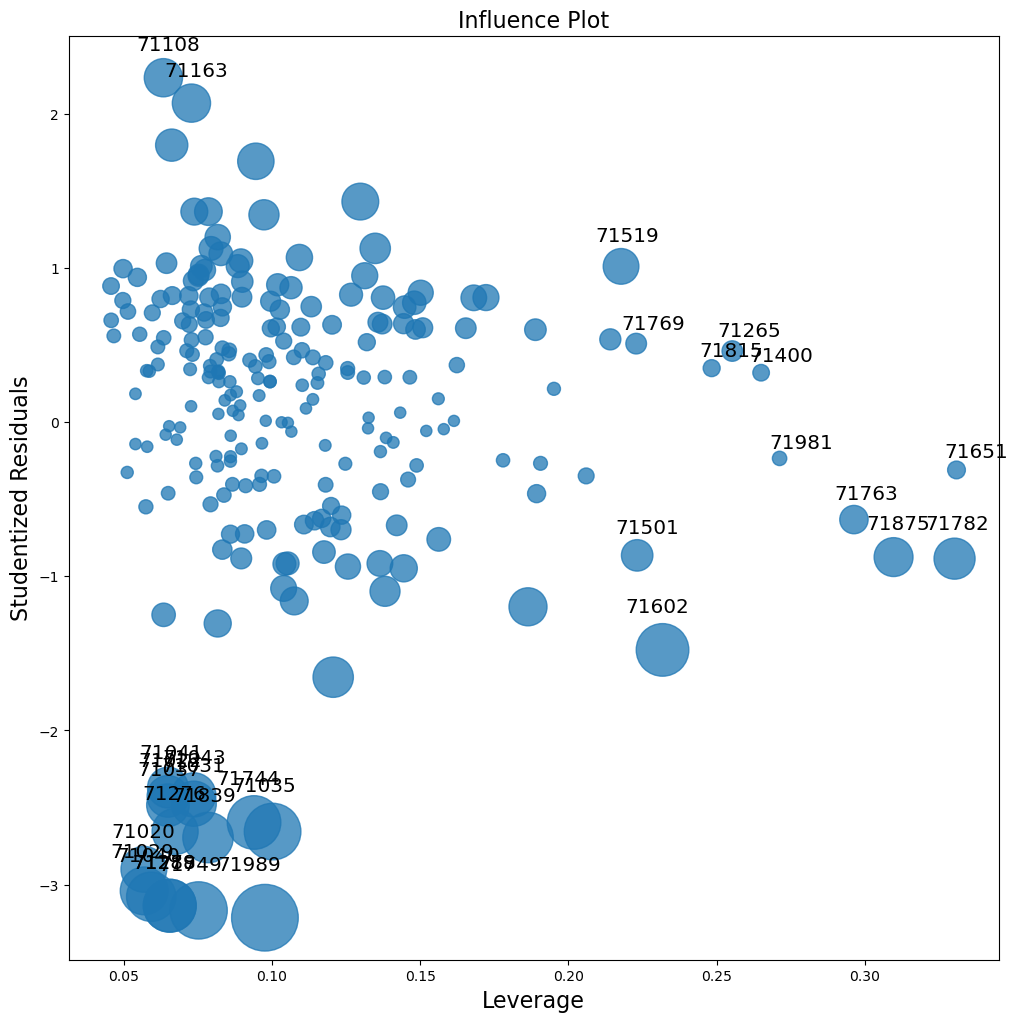

In [468]:
fig, ax = plt.subplots(figsize=(12,12))
fig = sm.graphics.influence_plot(reg_metal, ax=ax, criterion="cooks") 

In [469]:
reg_studs = infl.resid_studentized_external

In [470]:
inflsum = infl.summary_frame()
reg_cook = inflsum.cooks_d

In [477]:
metal_df['ext_stud_resid'] = reg_studs
metal_df['cooks_d'] = reg_cook

/var/folders/jk/pgjk_zys001_s284g_c6wyww0000gn/T/ipykernel_15562/3290285208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metal_df['ext_stud_resid'] = reg_studs
/var/folders/jk/pgjk_zys001_s284g_c6wyww0000gn/T/ipykernel_15562/3290285208.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metal_df['cooks_d'] = reg_cook


In [478]:
n = len(metal_df)
p = 15
t_crit = scipy.stats.t.ppf(0.975, df=n-p-1)
cook_crit = 4/n

In [479]:
clean_metal = metal_df[(abs(metal_df['ext_stud_resid'])<t_crit) & (abs(metal_df['cooks_d'])<cook_crit)]
clean_metal

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,time_4,ext_stud_resid,cooks_d
71002,0WSa1sucoNRcEeULlZVQXj,Bring Me The Horizon,Sempiternal (Expanded Edition),Can You Feel My Heart,81,228146,True,0.150,0.859,4,...,0.002010,0.194000,0.3870,0.354,170.527,5,metal,False,0.602360,0.002537
71051,4xDwCYhobDehSBGUmd5H6Y,The Plot In You,DISPOSE,FEEL NOTHING,76,216826,True,0.448,0.825,4,...,0.003530,0.000000,0.1080,0.226,144.170,4,metal,True,0.467141,0.000820
71055,0v1XpBHnsbkCn7iJ9Ucr1l,Bon Jovi,Crush,It's My Life,80,224493,False,0.551,0.913,0,...,0.026300,0.000013,0.3470,0.544,119.992,4,metal,True,1.798553,0.009063
71207,1zng9uqqXoPkmU05nsAlsw,Bon Jovi,Keep The Faith,Bed Of Roses,74,394400,False,0.309,0.596,5,...,0.101000,0.000000,0.2100,0.161,164.587,3,metal,False,0.775703,0.004188
71211,27k9Vb6ko9YYK6N8EJ8SA5,Bon Jovi,Cross Road (Sound & Vision) [International Ver...,Always,46,353320,False,0.377,0.658,4,...,0.117000,0.000000,0.0677,0.307,143.713,4,metal,True,-0.826415,0.002483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71985,4CYWDYubFT02pnEvSylECN,Pentagram,MMXII,Doğmadan Önce,38,351773,False,0.572,0.826,11,...,0.007200,0.004750,0.1140,0.327,125.792,4,metal,True,-1.305826,0.006043
71986,2hUvo9TxVWCbszNphTtNlJ,Malt,Kendi Adını Taşıyan İlk Albüm,Aşkın Gözü,39,237865,False,0.635,0.761,9,...,0.000538,0.000659,0.3070,0.538,139.972,3,metal,False,-0.668895,0.002971
71987,0bUgTRe5st6TMbRCEjKezX,Sabaton,The Last Stand,The Last Stand,68,235840,False,0.519,0.935,7,...,0.004540,0.000000,0.0661,0.498,104.044,4,metal,True,0.799981,0.001706
71991,1MNCcudzcgmrjWOwzNo661,Dymytry,Pharmageddon,Země Krále Miroslava,39,194016,False,0.538,0.915,10,...,0.000047,0.007890,0.1150,0.580,135.013,4,metal,True,-0.542988,0.001612


In [480]:
reg2 = smf.ols('popularity ~ duration_ms + C(explicit) + danceability + energy + C(key) + loudness + C(mode) + speechiness + acousticness + instrumentalness + liveness + valence + tempo + time_4', data=clean_metal).fit()

In [ ]:
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     2.243
Date:                Sun, 08 Oct 2023   Prob (F-statistic):            0.00142
Time:                        16:25:21   Log-Likelihood:                -786.89
No. Observations:                 211   AIC:                             1624.
Df Residuals:                     186   BIC:                             1708.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              79.5638     11.744      6.775      0.000      56.396     102.731
C(explicit)[T.True]     1.8193      2.024      0.899      0.370      -2.174       5.812
C(key)[T.1]            -2.3571      4.078     -0.578      0.564     -10.402       5.688
C(key)[T.2]             1.5884      3.629      0.438      0.662      -5.571       8.747
C(key)[T.3]             3.7707      6.222      0.606      0.545      -8.505      16.046
C(key)[T.4]             0.8951      4.074      0.220      0.826      -7.141       8.932
C(key)[T.5]             0.6722      4.348      0.155      0.877      -7.905       9.249
C(key)[T.6]             1.5572      4.172      0.373      0.709      -6.673       9.788
C(key)[T.7]            -1.6421      3.660     -0.449      0.654      -8.862       5.578
C(key)[T.8]            -0.8459      4.866     -0.174      0.862     -10.445       8.754
C(key)[T.9]            -2.3427      4.268     -0.549      0.584     -10.763       6.077
C(key)[T.10]           -7.7554      4.741     -1.636      0.104     -17.109       1.598
C(key)[T.11]           -1.7716      4.019     -0.441      0.660      -9.701       6.158
C(mode)[T.1]           -0.0322      1.693     -0.019      0.985      -3.372       3.308
time_4[T.True]          1.3661      2.938      0.465      0.643      -4.431       7.163
duration_ms          1.141e-05   1.26e-05      0.907      0.365   -1.34e-05    3.62e-05
danceability          -16.1288      8.543     -1.888      0.061     -32.983       0.725
energy                  2.5354      9.365      0.271      0.787     -15.940      21.011
loudness                1.0667      0.574      1.858      0.065      -0.066       2.199
speechiness           -10.6047     16.832     -0.630      0.529     -43.811      22.601
acousticness          -10.7120     10.008     -1.070      0.286     -30.456       9.032
instrumentalness       -1.1999      6.556     -0.183      0.855     -14.133      11.733
liveness                6.4045      4.832      1.325      0.187      -3.128      15.937
valence                -7.7350      4.612     -1.677      0.095     -16.834       1.364
tempo                  -0.0678      0.028     -2.428      0.016      -0.123      -0.013
==============================================================================
Omnibus:                       11.569   Durbin-Watson:                   1.510
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.241
Skew:                          -0.589   Prob(JB):                      0.00220
Kurtosis:                       3.070   Cond. No.                     6.44e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.44e+06. 

### Heteroscedasticity
- no issue

In [ ]:
pred = reg2.fittedvalues
res = reg2.resid

Text(0.5, 1.0, 'Fitted Values vs. Residuals')

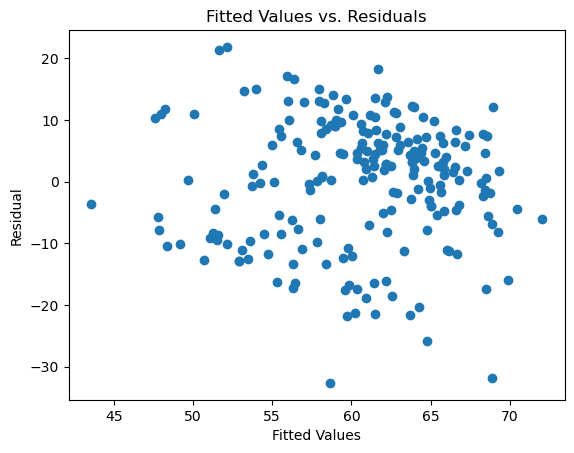

In [ ]:
plt.scatter(pred, res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

In [ ]:
bp_test = het_breuschpagan(res, reg2.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 20.48646729015268, 'LM-Test p-value': 0.6688025996882461}


### Normality

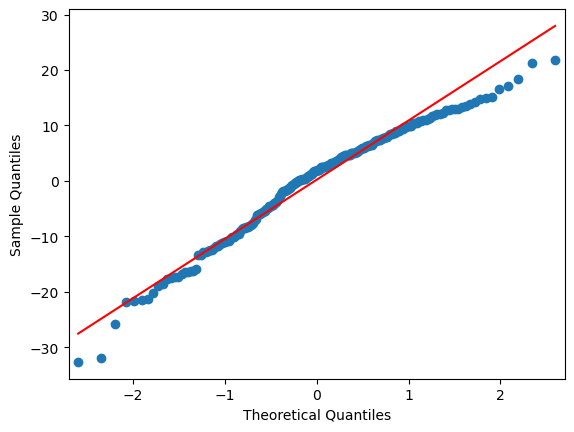

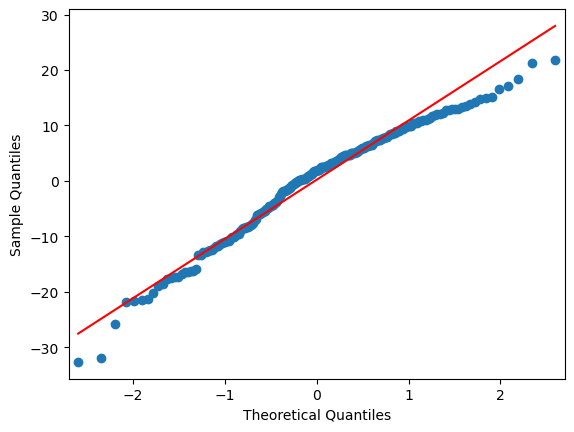

In [ ]:
sm.qqplot(res, line='q')

In [ ]:
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     2.243
Date:                Sun, 08 Oct 2023   Prob (F-statistic):            0.00142
Time:                        16:27:02   Log-Likelihood:                -786.89
No. Observations:                 211   AIC:                             1624.
Df Residuals:                     186   BIC:                             1708.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              79.5638     11.744      6.775      0.000      56.396     102.731
C(explicit)[T.True]     1.8193      2.024      0.899      0.370      -2.174       5.812
C(key)[T.1]            -2.3571      4.078     -0.578      0.564     -10.402       5.688
C(key)[T.2]             1.5884      3.629      0.438      0.662      -5.571       8.747
C(key)[T.3]             3.7707      6.222      0.606      0.545      -8.505      16.046
C(key)[T.4]             0.8951      4.074      0.220      0.826      -7.141       8.932
C(key)[T.5]             0.6722      4.348      0.155      0.877      -7.905       9.249
C(key)[T.6]             1.5572      4.172      0.373      0.709      -6.673       9.788
C(key)[T.7]            -1.6421      3.660     -0.449      0.654      -8.862       5.578
C(key)[T.8]            -0.8459      4.866     -0.174      0.862     -10.445       8.754
C(key)[T.9]            -2.3427      4.268     -0.549      0.584     -10.763       6.077
C(key)[T.10]           -7.7554      4.741     -1.636      0.104     -17.109       1.598
C(key)[T.11]           -1.7716      4.019     -0.441      0.660      -9.701       6.158
C(mode)[T.1]           -0.0322      1.693     -0.019      0.985      -3.372       3.308
time_4[T.True]          1.3661      2.938      0.465      0.643      -4.431       7.163
duration_ms          1.141e-05   1.26e-05      0.907      0.365   -1.34e-05    3.62e-05
danceability          -16.1288      8.543     -1.888      0.061     -32.983       0.725
energy                  2.5354      9.365      0.271      0.787     -15.940      21.011
loudness                1.0667      0.574      1.858      0.065      -0.066       2.199
speechiness           -10.6047     16.832     -0.630      0.529     -43.811      22.601
acousticness          -10.7120     10.008     -1.070      0.286     -30.456       9.032
instrumentalness       -1.1999      6.556     -0.183      0.855     -14.133      11.733
liveness                6.4045      4.832      1.325      0.187      -3.128      15.937
valence                -7.7350      4.612     -1.677      0.095     -16.834       1.364
tempo                  -0.0678      0.028     -2.428      0.016      -0.123      -0.013
==============================================================================
Omnibus:                       11.569   Durbin-Watson:                   1.510
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.241
Skew:                          -0.589   Prob(JB):                      0.00220
Kurtosis:                       3.070   Cond. No.                     6.44e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.44e+06. 